<a href="https://colab.research.google.com/github/ravigv/data/blob/master/FEcolabV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

# Load libraries

import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = 'https://raw.githubusercontent.com/ravigv/data/master/wb_causecode_data1.csv'
df = pd.read_csv(url)
print('Training data shape: ', df.shape)
df.head()

Training data shape:  (66840, 10)


,causecode_id,DESCRIPTION,CAUSE_DESC_LEVL2,CAUSE_DESC_LEVL3,tower,cc,cluster,impact,Operational_Categorization_Tier_1,technology
0,946,Access,Approval,Access/SAP Issue/Unable to access environment,IMD,IMD,SAP BI,4 - Individual,Investigate > Performance,SAP
1,549,Request,Enquiry,Information,IMD,IMD,SAP BI,4 - Individual,Inquiry > On Process,SAP
2,910,Access,Request,Unlock,IMD,IMD,SAP BI,4 - Individual,Inquiry,SAP
3,77,Access,Issue,Unable to access environment,IMD,IMD,SAP BI,4 - Individual,Add > Access,SAP
4,77,Access,Issue,Unable to access environment,IMD,IMD,SAP BI,4 - Individual,Inquiry > How Do I?,SAP


In [3]:
# # Create target variable a combination of cause codes
df['combined']= df['DESCRIPTION'].astype(str) + ' '+df['CAUSE_DESC_LEVL2'].astype(str) + ' ' + df['CAUSE_DESC_LEVL3'].astype(str)

In [4]:
# Function to examine Missing Values

# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(20)

Your selected dataframe has 11 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
Operational_Categorization_Tier_1,3831,5.7
tower,753,1.1
cc,753,1.1
cluster,753,1.1


In [6]:
# Drop missing values
df1 = df.dropna()

In [7]:
# Missing values statistics
missing_values = missing_values_table(df1)
missing_values.head(20)

Your selected dataframe has 11 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [8]:
# Number of unique classes in each object column
df1.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

DESCRIPTION                           50
CAUSE_DESC_LEVL2                     175
CAUSE_DESC_LEVL3                     560
tower                                  3
cc                                    10
cluster                               31
impact                                 7
Operational_Categorization_Tier_1    124
technology                            10
combined                             666
dtype: int64

In [9]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df1:
    if df1[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df1[col].unique())) <= 40:
            # Train on the training data
            le.fit(df1[col])
            # Transform both training and testing data
            df1[col] = le.transform(df1[col])
            #df1[col] = le.transform(df1[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

5 columns were label encoded.


In [10]:
#Label encoding for target variable - combined cause code
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Encode labels
df1['combined']= le.fit_transform(df1['combined'])

df1

,causecode_id,DESCRIPTION,CAUSE_DESC_LEVL2,CAUSE_DESC_LEVL3,tower,cc,cluster,impact,Operational_Categorization_Tier_1,technology,combined
0,946,Access,Approval,Access/SAP Issue/Unable to access environment,0,4,25,5,Investigate > Performance,7,0
1,549,Request,Enquiry,Information,0,4,25,5,Inquiry > On Process,7,580
2,910,Access,Request,Unlock,0,4,25,5,Inquiry,7,26
3,77,Access,Issue,Unable to access environment,0,4,25,5,Add > Access,7,6
4,77,Access,Issue,Unable to access environment,0,4,25,5,Inquiry > How Do I?,7,6
...,...,...,...,...,...,...,...,...,...,...,...
66835,575,Application,Deal,Inclusion list,2,0,6,4,Failure,7,136
66836,686,Application,Deal,Deal Lock,2,0,6,6,Inquiry / Help,7,123
66837,899,Application,Deal,Check out boxes issue,2,0,6,6,Inquiry / Help,7,118
66838,848,Application,Change Order,Date Issue,2,0,6,4,Failure,7,58


In [11]:
# one-hot encoding of categorical variables
df2 = pd.get_dummies(df1)
print('Features shape: ', df2.shape)

df2.head()

Features shape:  (62256, 916)


,causecode_id,tower,cc,cluster,impact,technology,combined,DESCRIPTION_Access,DESCRIPTION_Application,DESCRIPTION_Approval,DESCRIPTION_Archival,DESCRIPTION_Asset search,DESCRIPTION_Authorization,DESCRIPTION_Backup,DESCRIPTION_Batch Job,DESCRIPTION_Capacity,DESCRIPTION_Check transmission,DESCRIPTION_Code,DESCRIPTION_Configuration,DESCRIPTION_Cosmos IPM,DESCRIPTION_Data,DESCRIPTION_Data,DESCRIPTION_Delete,DESCRIPTION_File,DESCRIPTION_General,DESCRIPTION_Hardware,DESCRIPTION_Implementation of OSS notes,DESCRIPTION_Interface,DESCRIPTION_Invalid,DESCRIPTION_Job,DESCRIPTION_Job/Process,DESCRIPTION_Middleware,DESCRIPTION_Network,DESCRIPTION_Order,DESCRIPTION_PAR form not being sent to licensee,DESCRIPTION_PORT,DESCRIPTION_Program,DESCRIPTION_Project,DESCRIPTION_Purchase Order,DESCRIPTION_Report,...,Operational_Categorization_Tier_1_Install > Procure > Quote,Operational_Categorization_Tier_1_Install > Refresh,Operational_Categorization_Tier_1_Install > Server,Operational_Categorization_Tier_1_Install > Software,Operational_Categorization_Tier_1_Investigate,Operational_Categorization_Tier_1_Investigate > Access,Operational_Categorization_Tier_1_Investigate > Account,Operational_Categorization_Tier_1_Investigate > Batch,Operational_Categorization_Tier_1_Investigate > Connectivity,Operational_Categorization_Tier_1_Investigate > Data Query,Operational_Categorization_Tier_1_Investigate > Desktop Client/Configuration,Operational_Categorization_Tier_1_Investigate > Estimate,Operational_Categorization_Tier_1_Investigate > ITSR Request,Operational_Categorization_Tier_1_Investigate > Interface,Operational_Categorization_Tier_1_Investigate > Performance,Operational_Categorization_Tier_1_Investigate > Refresh,Operational_Categorization_Tier_1_Investigate > SAP Transport,Operational_Categorization_Tier_1_Investigate > Security,Operational_Categorization_Tier_1_Investigate > Sizing Estimate,Operational_Categorization_Tier_1_Investigate > Space,Operational_Categorization_Tier_1_Investigate > Transaction,Operational_Categorization_Tier_1_Move,Operational_Categorization_Tier_1_Move > Refresh,Operational_Categorization_Tier_1_Restore/Reset > Access,Operational_Categorization_Tier_1_Restore/Reset > Data,Operational_Categorization_Tier_1_Restore/Reset > File,Operational_Categorization_Tier_1_Restore/Reset > Password,Operational_Categorization_Tier_1_Restore/Reset > Server,Operational_Categorization_Tier_1_Run,Operational_Categorization_Tier_1_Run > Backup,Operational_Categorization_Tier_1_Run > Batch,Operational_Categorization_Tier_1_Run > Extract,Operational_Categorization_Tier_1_Run > ITSR Request,Operational_Categorization_Tier_1_Run > Job,Operational_Categorization_Tier_1_Run > Report,Operational_Categorization_Tier_1_Train > ITSR Request,Operational_Categorization_Tier_1_Train > ITSR Request > ITSR-Server/Service Request,Operational_Categorization_Tier_1_Uninstall > Server,Operational_Categorization_Tier_1_Uninstall > Server > Password,Operational_Categorization_Tier_1_Uninstall > Termination
0,946,0,4,25,5,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,549,0,4,25,5,7,580,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,910,0,4,25,5,7,26,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,77,0,4,25,5,7,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,77,0,4,25,5,7,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# Rearranging combined column to end of df 
dfpop = df2.pop('combined') # remove column b and store it in df1
df2['combined']= dfpop # add b series as a 'new' column.
df2.head()


,causecode_id,tower,cc,cluster,impact,technology,DESCRIPTION_Access,DESCRIPTION_Application,DESCRIPTION_Approval,DESCRIPTION_Archival,DESCRIPTION_Asset search,DESCRIPTION_Authorization,DESCRIPTION_Backup,DESCRIPTION_Batch Job,DESCRIPTION_Capacity,DESCRIPTION_Check transmission,DESCRIPTION_Code,DESCRIPTION_Configuration,DESCRIPTION_Cosmos IPM,DESCRIPTION_Data,DESCRIPTION_Data,DESCRIPTION_Delete,DESCRIPTION_File,DESCRIPTION_General,DESCRIPTION_Hardware,DESCRIPTION_Implementation of OSS notes,DESCRIPTION_Interface,DESCRIPTION_Invalid,DESCRIPTION_Job,DESCRIPTION_Job/Process,DESCRIPTION_Middleware,DESCRIPTION_Network,DESCRIPTION_Order,DESCRIPTION_PAR form not being sent to licensee,DESCRIPTION_PORT,DESCRIPTION_Program,DESCRIPTION_Project,DESCRIPTION_Purchase Order,DESCRIPTION_Report,DESCRIPTION_Request,...,Operational_Categorization_Tier_1_Install > Refresh,Operational_Categorization_Tier_1_Install > Server,Operational_Categorization_Tier_1_Install > Software,Operational_Categorization_Tier_1_Investigate,Operational_Categorization_Tier_1_Investigate > Access,Operational_Categorization_Tier_1_Investigate > Account,Operational_Categorization_Tier_1_Investigate > Batch,Operational_Categorization_Tier_1_Investigate > Connectivity,Operational_Categorization_Tier_1_Investigate > Data Query,Operational_Categorization_Tier_1_Investigate > Desktop Client/Configuration,Operational_Categorization_Tier_1_Investigate > Estimate,Operational_Categorization_Tier_1_Investigate > ITSR Request,Operational_Categorization_Tier_1_Investigate > Interface,Operational_Categorization_Tier_1_Investigate > Performance,Operational_Categorization_Tier_1_Investigate > Refresh,Operational_Categorization_Tier_1_Investigate > SAP Transport,Operational_Categorization_Tier_1_Investigate > Security,Operational_Categorization_Tier_1_Investigate > Sizing Estimate,Operational_Categorization_Tier_1_Investigate > Space,Operational_Categorization_Tier_1_Investigate > Transaction,Operational_Categorization_Tier_1_Move,Operational_Categorization_Tier_1_Move > Refresh,Operational_Categorization_Tier_1_Restore/Reset > Access,Operational_Categorization_Tier_1_Restore/Reset > Data,Operational_Categorization_Tier_1_Restore/Reset > File,Operational_Categorization_Tier_1_Restore/Reset > Password,Operational_Categorization_Tier_1_Restore/Reset > Server,Operational_Categorization_Tier_1_Run,Operational_Categorization_Tier_1_Run > Backup,Operational_Categorization_Tier_1_Run > Batch,Operational_Categorization_Tier_1_Run > Extract,Operational_Categorization_Tier_1_Run > ITSR Request,Operational_Categorization_Tier_1_Run > Job,Operational_Categorization_Tier_1_Run > Report,Operational_Categorization_Tier_1_Train > ITSR Request,Operational_Categorization_Tier_1_Train > ITSR Request > ITSR-Server/Service Request,Operational_Categorization_Tier_1_Uninstall > Server,Operational_Categorization_Tier_1_Uninstall > Server > Password,Operational_Categorization_Tier_1_Uninstall > Termination,combined
0,946,0,4,25,5,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,549,0,4,25,5,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,580
2,910,0,4,25,5,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26
3,77,0,4,25,5,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
4,77,0,4,25,5,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6


In [13]:
X = df2.iloc[:,0:915]  #independent columns
y = df2.iloc[:,-1]    #target column i.e combined cause code

In [14]:
# Find correlations with the target and sort
correlations = df2.corr()['combined'].sort_values()
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))


Most Positive Correlations:
 CAUSE_DESC_LEVL3_Records missing in table                     0.131537
Operational_Categorization_Tier_1_Investigate > Data Query    0.135526
CAUSE_DESC_LEVL3_Report Run                                   0.151158
Operational_Categorization_Tier_1_Inquiry                     0.173336
CAUSE_DESC_LEVL2_Mismatch                                     0.214983
CAUSE_DESC_LEVL3_Data Update Request                          0.214997
DESCRIPTION_Report                                            0.216716
CAUSE_DESC_LEVL3_Information                                  0.310851
CAUSE_DESC_LEVL2_Enquiry                                      0.332867
CAUSE_DESC_LEVL3_General Service request                      0.344762
DESCRIPTION_General                                           0.348392
DESCRIPTION_Request                                           0.352599
cc                                                            0.460292
DESCRIPTION_Data                                

In [15]:
# Create correlated matrix and drop columns highly correlated
# Create correlation matrix
corr_matrix = df2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df2.drop(to_drop, axis=1, inplace=True)
df2

,causecode_id,tower,cc,cluster,impact,technology,DESCRIPTION_Access,DESCRIPTION_Application,DESCRIPTION_Approval,DESCRIPTION_Archival,DESCRIPTION_Asset search,DESCRIPTION_Authorization,DESCRIPTION_Backup,DESCRIPTION_Batch Job,DESCRIPTION_Capacity,DESCRIPTION_Check transmission,DESCRIPTION_Code,DESCRIPTION_Configuration,DESCRIPTION_Cosmos IPM,DESCRIPTION_Data,DESCRIPTION_Data,DESCRIPTION_Delete,DESCRIPTION_File,DESCRIPTION_General,DESCRIPTION_Hardware,DESCRIPTION_Implementation of OSS notes,DESCRIPTION_Interface,DESCRIPTION_Invalid,DESCRIPTION_Job,DESCRIPTION_Job/Process,DESCRIPTION_Middleware,DESCRIPTION_Network,DESCRIPTION_Order,DESCRIPTION_PAR form not being sent to licensee,DESCRIPTION_PORT,DESCRIPTION_Program,DESCRIPTION_Project,DESCRIPTION_Purchase Order,DESCRIPTION_Report,DESCRIPTION_Request,...,Operational_Categorization_Tier_1_Install > Refresh,Operational_Categorization_Tier_1_Install > Server,Operational_Categorization_Tier_1_Install > Software,Operational_Categorization_Tier_1_Investigate,Operational_Categorization_Tier_1_Investigate > Access,Operational_Categorization_Tier_1_Investigate > Account,Operational_Categorization_Tier_1_Investigate > Batch,Operational_Categorization_Tier_1_Investigate > Connectivity,Operational_Categorization_Tier_1_Investigate > Data Query,Operational_Categorization_Tier_1_Investigate > Desktop Client/Configuration,Operational_Categorization_Tier_1_Investigate > Estimate,Operational_Categorization_Tier_1_Investigate > ITSR Request,Operational_Categorization_Tier_1_Investigate > Interface,Operational_Categorization_Tier_1_Investigate > Performance,Operational_Categorization_Tier_1_Investigate > Refresh,Operational_Categorization_Tier_1_Investigate > SAP Transport,Operational_Categorization_Tier_1_Investigate > Security,Operational_Categorization_Tier_1_Investigate > Sizing Estimate,Operational_Categorization_Tier_1_Investigate > Space,Operational_Categorization_Tier_1_Investigate > Transaction,Operational_Categorization_Tier_1_Move,Operational_Categorization_Tier_1_Move > Refresh,Operational_Categorization_Tier_1_Restore/Reset > Access,Operational_Categorization_Tier_1_Restore/Reset > Data,Operational_Categorization_Tier_1_Restore/Reset > File,Operational_Categorization_Tier_1_Restore/Reset > Password,Operational_Categorization_Tier_1_Restore/Reset > Server,Operational_Categorization_Tier_1_Run,Operational_Categorization_Tier_1_Run > Backup,Operational_Categorization_Tier_1_Run > Batch,Operational_Categorization_Tier_1_Run > Extract,Operational_Categorization_Tier_1_Run > ITSR Request,Operational_Categorization_Tier_1_Run > Job,Operational_Categorization_Tier_1_Run > Report,Operational_Categorization_Tier_1_Train > ITSR Request,Operational_Categorization_Tier_1_Train > ITSR Request > ITSR-Server/Service Request,Operational_Categorization_Tier_1_Uninstall > Server,Operational_Categorization_Tier_1_Uninstall > Server > Password,Operational_Categorization_Tier_1_Uninstall > Termination,combined
0,946,0,4,25,5,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,549,0,4,25,5,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,580
2,910,0,4,25,5,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26
3,77,0,4,25,5,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
4,77,0,4,25,5,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [16]:
#apply SelectKBest class to extract top 10 best features - Chi square for feature selection
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)

In [17]:
# Get scores and column names
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [18]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns

In [19]:
# Get 10 best features
# featureScores.sort_values(by=['Score'], ascending=False)
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                         Features         Score
0                                    causecode_id  1.057229e+07
3                                         cluster  1.369114e+05
2                                              cc  8.410406e+04
69                         CAUSE_DESC_LEVL2_CHARM  6.225500e+04
272                  CAUSE_DESC_LEVL3_Avails List  6.225500e+04
302  CAUSE_DESC_LEVL3_CUI - Eapproval Portal Role  6.225500e+04
386                CAUSE_DESC_LEVL3_Email address  6.225500e+04
390              CAUSE_DESC_LEVL3_End Notes Issue  6.225500e+04
394     CAUSE_DESC_LEVL3_Enterprise Scan profiles  6.225500e+04
489                     CAUSE_DESC_LEVL3_LF Issue  6.225500e+04


In [20]:
# Feature selection by ExtraTreesClassifier - multiple de-correlated decision trees
from sklearn.ensemble import ExtraTreesClassifier 
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [21]:
# use inbuilt class feature_importances of tree based classifiers
print(model.feature_importances_)

[6.81908220e-02 6.14926504e-03 1.13864442e-02 1.24047528e-02
 1.03340138e-03 3.86516852e-03 2.62096220e-02 5.91189592e-03
 1.07625508e-03 9.92922376e-05 4.93393753e-06 1.32581105e-03
 5.01093586e-05 1.85405043e-03 1.32301781e-04 1.02730842e-03
 3.45941171e-04 1.81836915e-03 1.12006738e-05 1.70169909e-02
 2.59656730e-04 7.92280496e-05 5.58741367e-04 2.50397508e-02
 1.03525521e-04 5.17910295e-05 2.46174594e-04 5.65686556e-04
 1.63880434e-04 1.00255359e-03 3.46198344e-05 2.46706691e-04
 5.73924081e-04 3.45561775e-05 4.38919880e-06 5.16703331e-05
 1.15916917e-05 5.49113062e-04 6.04099484e-03 1.17225210e-02
 3.64335237e-04 1.15942804e-04 3.42707600e-04 5.79290757e-04
 5.24260856e-04 6.09527499e-04 4.30654305e-04 2.05821464e-05
 6.72278078e-05 9.46377328e-05 1.02670509e-04 5.97040101e-05
 3.18749950e-04 1.52083242e-05 3.68651225e-04 6.01834394e-05
 1.61248863e-04 4.48326583e-04 6.45496955e-05 8.25070576e-05
 3.88958618e-05 4.95413430e-04 1.11944482e-03 3.67285109e-04
 1.77857555e-04 4.499871

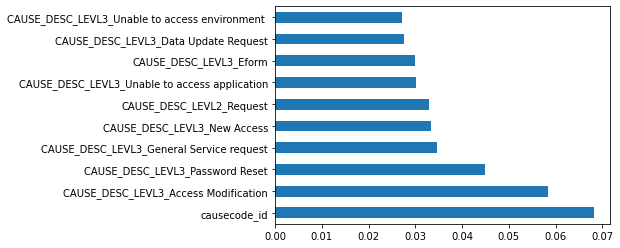

In [22]:
# Plotting top 10 feature importance by ExtraTreesClassifier
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Feature: 0, Score: 0.12016
Feature: 1, Score: 0.00463
Feature: 2, Score: 0.01571
Feature: 3, Score: 0.02116
Feature: 4, Score: 0.00172
Feature: 5, Score: 0.00541
Feature: 6, Score: 0.02091
Feature: 7, Score: 0.00570
Feature: 8, Score: 0.00109
Feature: 9, Score: 0.00010
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00126
Feature: 12, Score: 0.00005
Feature: 13, Score: 0.00169
Feature: 14, Score: 0.00013
Feature: 15, Score: 0.00099
Feature: 16, Score: 0.00031
Feature: 17, Score: 0.00154
Feature: 18, Score: 0.00001
Feature: 19, Score: 0.01654
Feature: 20, Score: 0.00024
Feature: 21, Score: 0.00007
Feature: 22, Score: 0.00051
Feature: 23, Score: 0.03048
Feature: 24, Score: 0.00011
Feature: 25, Score: 0.00006
Feature: 26, Score: 0.00025
Feature: 27, Score: 0.00054
Feature: 28, Score: 0.00018
Feature: 29, Score: 0.00109
Feature: 30, Score: 0.00004
Feature: 31, Score: 0.00029
Feature: 32, Score: 0.00045
Feature: 33, Score: 0.00003
Feature: 34, Score: 0.00001
Feature: 35, Score: 0.00004
Fe

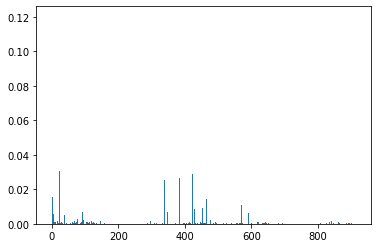

In [23]:
# Feature selection by Random forest
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

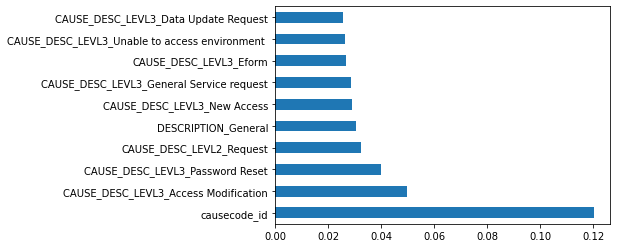

In [24]:
# Plotting top 10 feature importance by RandomForestClassifier
fimp = pd.Series(importance, index=X.columns)
fimp.nlargest(10).plot(kind='barh')
plt.show()

In [25]:
# xgboost for feature importance on a classification problem
from xgboost import XGBClassifier

model = XGBClassifier()

# fit the model
model.fit(X, y)

# get importance
importance1 = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance1):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.bar([x for x in range(len(importance1))], importance1)
plt.show()

KeyboardInterrupt: ignored

In [ ]:
# Plotting top 10 feature importance by XGBClassifier
fimp = pd.Series(importance1, index=X.columns)
fimp.nlargest(10).plot(kind='barh')
plt.show()

In [2]:
# Permutation Feature Importance for Classification
# permutation feature importance with knn for classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# define the model
model = KNeighborsClassifier()

# fit the model
model.fit(X, y)

# perform permutation importance
results = permutation_importance(model, X, y, scoring='accuracy')

# get importance
importance2 = results.importances_mean

# summarize feature importance
for i,v in enumerate(importance2):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
    
# plot feature importance
pyplot.bar([x for x in range(len(importance2))], importance2)
pyplot.show()

NameError: ignored

In [1]:
# Plotting top 10 feature importance by permutation_importance
fimp = pd.Series(importance2, index=X.columns)
fimp.nlargest(10).plot(kind='barh')
plt.show()

NameError: ignored